<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Avanzados en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Practical Assignment: Support Vector Machines</div><br>
    <div style="font-size: large">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div><br></div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook).

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from Utils import plot_dataset_clas, plot_svc

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the SVC class of `sklearn`.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

# SMO Algorithm

## Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

## SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this type of divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:
\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

## Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

## Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide a larger minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

## Stopping Criteria

The algorithm will be terminated when a certain maximum number of iteration is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

## Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

## Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

# Implementation of the SVC

## Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma='scale', tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs, each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X, y)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, X)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector

---
```python
predict(self, X)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

## Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bound $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

## Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [57]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

class MySVC():
    """
        SVC with a simplified version of SMO.
    """
    def __init__(self, C=1.0, gamma='scale', tol=0, max_iter=100):
        # Assignment of the hyper-parameters (complete).
        self.C = C
        self.gamma = gamma
        self.tol = tol
        self.max_iter = max_iter
        self.kernel = 'rbf'
        # ...

    def fit(self, X, y):
        # Constants.
        n_pat = X.shape[0]
        n_dim = X.shape[1]
        self.X = X
        self.y = y

        # Options for gamma (for compatibility with sklean).
        if (self.gamma == 'scale'):
            self.gamma = 1.0 / (n_dim * X.var())
        if (self.gamma == 'auto'):
            self.gamma = 1.0 / n_dim

        # Initialization of the dual coefficients (named "a" instead of "alpha" for simplicity).
        self.a = np.zeros(n_pat)

        # Other initializations (complete).
        # ...
        it = 0
        flag = 0

        # Loop over the iterations.
        #for it in range(self.max_iter):
        while(self.max_iter < 0 or it < self.max_iter):
            # Initializations (complete).
            # ...
            aold = self.a
            
            # Loop over the coefficients.
            for i in range(0, n_pat):
                j = self.choose_j(i)
                ajold = self.a[j]
                aiold = self.a[i]
                # Update of the corresponding a[i] and a[j] values (complete).
                # ...
                L, H = self.LH(i, j)
                d = self.d(i, j)
                self.a[j] = min(max(ajold + d, L), H)
                self.a[i] += - self.y[i]*self.y[j]*(self.a[j] - ajold)
            
            # Check of the stopping conditions (complete).
            # ...
            if np.linalg.norm(aold - self.a) < self.tol:
                break
            it += 1

        # Storage of the obtained parameters and computation of the intercept (complete).
        # ...
        self.support_ = np.where((self.a > 0) & (self.a <= self.C))
        self.support_vectors_ = self.X[self.support_]
        self.n_support_ = len(self.support_)
        
        self.intercept_ = self.b_star(self.support_)        
        return self

    def decision_function(self, X):
        # Computation of the decision function over X (complete).
        # ...
        return self.output(X) + self.intercept_

    def predict(self, X):
        # Computation of the predicted class over X (complete).
        # ...
        return np.sign(self.decision_function(X))

    # Auxiliary methods (complete if needed).
    def choose_j(self, i):
        v = np.arange(len(self.a))
        return np.random.choice(v[v != i])

    def output(self, X):
        return (self.a * self.y) @ rbf_kernel(self.X, X)
    
    def E(self, i):
        return self.output(self.X[i][None])[0] - self.y[i]
    
    def d(self, i, j):
        return (self.y[j]*(self.E(j) - self.E(i)))/(
            2*rbf_kernel(self.X[i][None], self.X[j][None])[0,0] - 
            rbf_kernel(self.X[i][None], self.X[i][None])[0,0] -
            rbf_kernel(self.X[j][None], self.X[j][None])[0,0])
    
    def LH(self, i, j):
        if(self.y[i] == self.y[j]):
            L = max(0, self.a[j] + self.a[i] - self.C)
            H = min(self.C, self.a[i] + self.a[j])
        else:
            L = max(0, self.a[j] - self.a[i])
            H = min(self.C, self.C - self.a[i] + self.a[j])
            
        return L, H

    def b_star(self, ind):
        return np.mean(self.y[ind] - self.output(self.X[ind]))
        
    # ...

# Experiments with the SVC

## Comparative with *scikit-learn*

The following cell generates the *moons* dataset, dividing it into train and test splits, and depicting it.

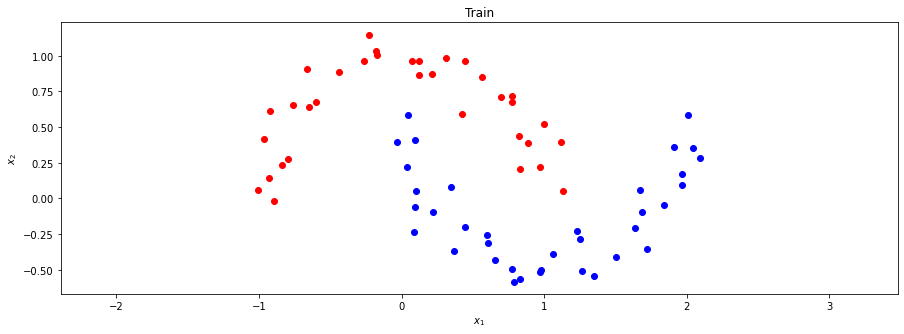

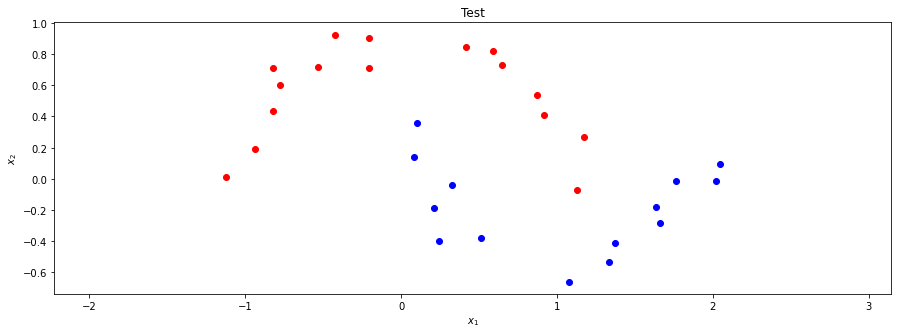

In [58]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

x, y = make_moons(noise=1e-1, random_state=seed)
y[y != 1] = -1

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=seed)

plot_dataset_clas(x_tr, y_tr)
plt.title('Train'); plt.show()
plot_dataset_clas(x_te, y_te)
plt.title('Test'); plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of `sklearn` and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results. If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

False

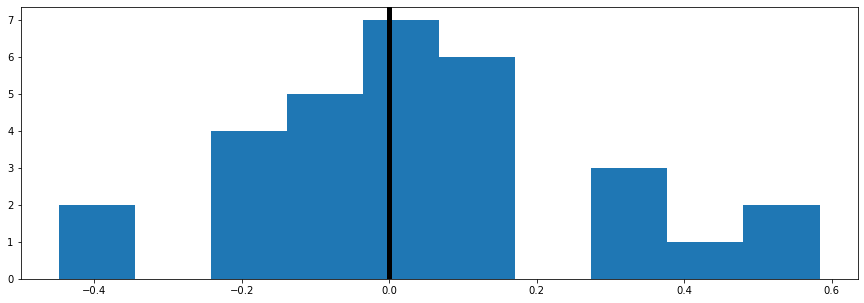

In [59]:
C = 1e0
gamma = 'scale'

model_my = MySVC(C=C, gamma=gamma)
model_sk = SVC(C=C, gamma=gamma)

# Training of the models (complete).
# ...
model_my.fit(x_tr, y_tr)
model_sk.fit(x_tr, y_tr)

# Comparative of the predicted scores (complete).
# ...
h = model_my.decision_function(x_te) - model_sk.decision_function(x_te)
plt.hist(h)
plt.axvline(x=0, color='black', linewidth=5)

# Comparative of the predicted classes (complete).
# ...
(model_my.predict(x_te) == model_sk.predict(x_te)).all()

/home/oscar/Escritorio/MUCD/MUCD-MAAA/Practica 1/Utils.py:431: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, np.sign(zz), shading='flat', cmap=colors.ListedColormap([alpha * col_2 + 1 - alpha, alpha * col_1 + 1 - alpha]))


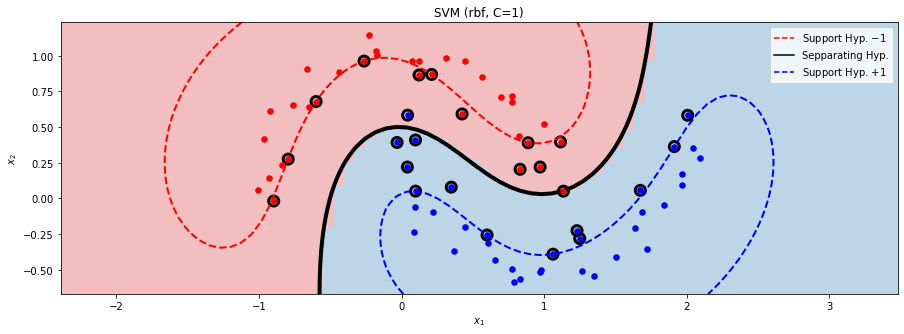

In [60]:
plot_svc(x_tr, y_tr, model_sk)

/home/oscar/Escritorio/MUCD/MUCD-MAAA/Practica 1/Utils.py:431: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, np.sign(zz), shading='flat', cmap=colors.ListedColormap([alpha * col_2 + 1 - alpha, alpha * col_1 + 1 - alpha]))


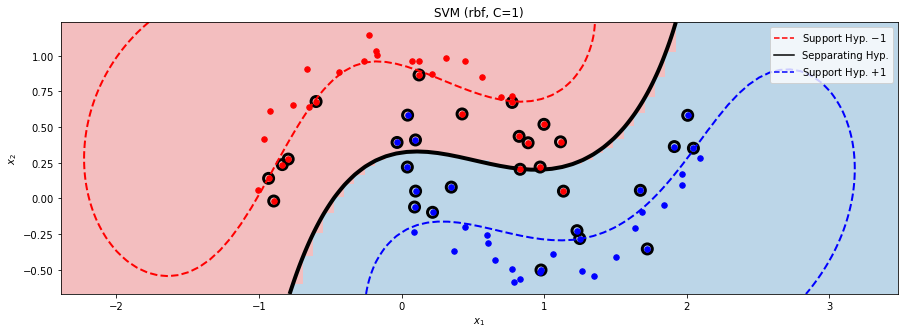

In [61]:
plot_svc(x_tr, y_tr, model_my)

## Understanding the SVM

<div class="qst">

* Considering the model created with the `MySVC` class:
    * Extract the list of support vectors, explaining the followed approach.
    * Extract the list of training points bad and well classified, explaining the followed approach.
    * Extract the list of training points that lie over the supporting hyperplanes.
    * Extract the list of training points located on the wrong side of the supporting hyperplanes, but that are well classified.
* What are the conditions over the dual coefficients $\alpha_i$ that characterize the previous lists (if any)?

</div>

In [79]:
# Extraction of the lists (complete).
# ...

# The support vectors correspond to the vectors which correspondig alpha is in (0, C].
# We will print the indices of those vectors to give an understandable list.
print("Support vector indices:", model_my.support_[0])
print("Support vector alphas:", model_my.a[model_my.support_])

# The support vectors that are well classified and in the correct side of the hyperplane
# takes an alpha value equal to 0, so they dont have any impact on the model
well = np.where(model_my.a == 0)
print("Points well classified indices:", well)
print("Points well classified alphas:", model_my.a[well])

# For the points that are well classified and in the hyperplane, the alpha will take a value in (0,C)
hyper = np.where((model_my.a > 0) & (model_my.a < model_my.C))
print("Points in the hyperplanes indices:", hyper)
print("Points in the hyperplanes alphas:", model_my.a[hyper])

# To see if the points that are on the wrong side of the hyperplane (alpha = C) are well
# classified we need to check the output
nh = np.where(model_my.a == C)
nh_well = nh[0][model_my.predict(model_my.X[nh]) == model_my.y[nh]]
nh_wrong = nh[0][model_my.predict(model_my.X[nh]) != model_my.y[nh]]
print("Points bad classfied indices:", nh_wrong)
print("Points bad classfied alphas:", model_my.a[nh_wrong])
print("Points well classfied but wrong side indices:", nh_well)
print("Points well classfied but wrong side alphas:", model_my.a[nh_well])

Support vector indices: [ 1  3  6  8 12 15 19 20 24 26 27 29 30 31 32 37 41 42 43 44 45 47 50 52
 53 55 57 62 66 68 69]
Support vector alphas: [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.21145785e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 7.56369856e-01
 1.11022302e-16 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.78059931e-01 1.86715998e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.11022302e-16 1.00000000e+00]
Points well classified indices: (array([ 0,  2,  4,  5,  7,  9, 10, 11, 13, 14, 16, 17, 18, 21, 22, 23, 25,
       28, 33, 34, 35, 36, 38, 39, 40, 46, 48, 49, 51, 54, 56, 58, 59, 60,
       61, 63, 64, 65, 67]),)
Points well classified alphas: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Points in the hyper